In [ ]:
#%%writefile merge_df.py
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')


import build_financial_df as fin
import build_results_df as res
merge_df_start = res.results_GE.merge(fin.finance_df, how="inner", left_on="elec-cand", right_on="ELEC-CAND")
merge_df_start.head(5)

#identify Senate (not success)
sen_bool = merge_df_start['office']=="US Senate"
merge_df_start['new_elec_id'] = merge_df_start['elec_id'].str.replace('-00','-SE')

# 8783 races that survived the data cull
num_cand = merge_df_start['new_elec_id'].value_counts()

# 6547 races with 2+ candidates that survived the data cull
num_cand_df = pd.DataFrame()
num_cand_df = num_cand[num_cand>1]
merge_df_cut = merge_df_start[merge_df_start['new_elec_id'].isin(num_cand_df.reset_index()['index'])]

# get top 2 candidates
top2_cand = merge_df_cut.groupby('new_elec_id')['vote%'].nlargest(2)

# make dictionary with values equal to set of names of top 2 candidates 
cand_pair_dct = {}
for pair in top2_cand.index:
    l_name = merge_df_cut.loc[pair[1], 'last_name']
    if pair[0] not in cand_pair_dct:
        cand_pair_dct[pair[0]] = set()
    cand_pair_dct[pair[0]].add(l_name)

    
# list of sets of rematch races
from itertools import chain
rev_dict = {}
for key, value in cand_pair_dct.items():
    rev_dict.setdefault(str(value), set()).add(key)
rematch_list = [values for key, values in rev_dict.items() if len(values) > 1]

# make df of rematches
all_rematch = []
for s in rematch_list:
    for x in s:
        if x not in all_rematch:
            all_rematch.append(x)

index_list = [top2_cand.index[i][1] for i in range(len(top2_cand))]
rematch_df_start = merge_df_start[merge_df_start.index.isin(index_list)]

#write function to get rematch table for each item in rematch_list
def get_rematch_table(idx):
    cand_rematch = merge_df_cut[merge_df_cut.loc[:, 'new_elec_id'].isin(rematch_list[idx])]
    return cand_rematch[['FEC_ID','new_elec_id','year', 'candidate', 'candidatevotes', 'office', 'party', 'state', 'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

rematch_cut = rematch_df_start[['FEC_ID','new_elec_id','year', 'candidate', 'candidatevotes', 'vote%', 'office', 'party', 'state', 'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]



### get data for delta_vote & delta_spend

for i in range(len(rematch_list)):
#for i in [1]:
    a = rematch_cut[rematch_cut['new_elec_id']==list(rematch_list[i])[0]].sort_values('FEC_ID').reset_index()
    b = rematch_cut[rematch_cut['new_elec_id']==list(rematch_list[i])[1]].sort_values('FEC_ID').reset_index()
    i1 = a['index'][0]
    i2 = a['index'][1]
    i3 = b['index'][0]
    i4 = b['index'][1]
    
    print(a)
    #calc delta_vote
    if a.loc[0,'office'] == a.loc[1,'office']:
        print(f"this should be good {i}")
        d_vote = a.loc[0, 'vote%'] - b.loc[0,'vote%']
        rematch_cut.loc[i1, 'delta_vote'] = d_vote
        rematch_cut.loc[i3, 'delta_vote'] = 0    

        d2_vote = a.loc[1, 'vote%'] - b.loc[1,'vote%']
        rematch_cut.loc[i2, 'delta_vote'] = d2_vote
        rematch_cut.loc[i4, 'delta_vote'] = 0 
    else:
        rematch_cut.loc[i1, 'delta_vote'] = None
        rematch_cut.loc[i3, 'delta_vote'] = None
        rematch_cut.loc[i2, 'delta_vote'] = None
        rematch_cut.loc[i4, 'delta_vote'] = None 

    # calc delta_spend
    if a.loc[0,'office'] == a.loc[1,'office']:
        d_vote = a.loc[0, 'TTL_DISB'] - b.loc[0,'TTL_DISB']
        rematch_cut.loc[i1, 'delta_spend'] = d_vote
        rematch_cut.loc[i3, 'delta_spend'] = 0    

        d2_vote = a.loc[1, 'TTL_DISB'] - b.loc[1,'TTL_DISB']
        rematch_cut.loc[i2, 'delta_spend'] = d2_vote
        rematch_cut.loc[i4, 'delta_spend'] = 0 
    else: 
        rematch_cut.loc[i1, 'delta_spend'] = None
        rematch_cut.loc[i3, 'delta_spend'] = None
        rematch_cut.loc[i2, 'delta_spend'] = None
        rematch_cut.loc[i4, 'delta_spend'] = None
        


'''
# eventually want to filter these weirdos because total vote % > 100%
sum_vote_percent = merge_df_cut.groupby('new_elec_id')['vote%'].nlargest(2).sum(level=0)
# below attempt didn't work
sum_percent_df = pd.DataFrame()
sum_percent_df = sum_vote_percent[sum_vote_percent<=100]
merge_df_cut2 = merge_df_cut[merge_df_cut['new_elec_id'].isin(sum_percent_df.reset_index()['index'])]
merge_df_cut2
'''

/Users/Kelly/galvanize/week4/Federal-Election-Funding/build_financial_df.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  fin_cut_1['ELEC-CAND'] = fin_cut_1["ELEC_ID"].astype(str) +"-"+ fin_cut_1["LAST_NAME"].astype(str)
/Users/Kelly/galvanize/week4/Federal-Election-Funding/build_results_df.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  results_raw = pd.concat([senate_data_80to18, results_data_80to18], axis=0)
/Users/Kelly/galvanize/week4/Federal-Election-Funding/build_results_df.py:27: SettingWithCopyWarning: 
A value is trying to be set on

   index     FEC_ID new_elec_id  year       candidate  candidatevotes  \
0  15219  H6AK00045  2016-AK-SE  2016       Don Young          155088   
1   1420  S4AK00099  2016-AK-SE  2016  Lisa Murkowski          138149   

       vote%     office       party   state   district INC_STATUS  totalvotes  \
0  50.320898   US House  republican  Alaska          0          I      308198   
1  44.358000  US Senate  republican  Alaska  statewide          I      311441   

   TTL_RECEIPTS    TTL_DISB  
0    1103561.86  1322055.12  
1    4431094.00  6010705.57  


/Users/Kelly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Kelly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


   index     FEC_ID new_elec_id  year                  candidate  \
0   1628  H0CA09018  1980-CA-09  1980  William J. (Bill) Kennedy   
1   1629  H6CA09023  1980-CA-09  1980    Fortney H. (Pete) Stark   

   candidatevotes      vote%    office       party       state district  \
0           67265  41.117536  US House  republican  California        9   
1           90504  55.322999  US House    democrat  California        9   

  INC_STATUS  totalvotes  TTL_RECEIPTS  TTL_DISB  delta_vote  delta_spend  
0        NaN      163592       31048.0   28806.0         NaN          NaN  
1          I      163592       32603.0   47194.0         NaN          NaN  
this should be good 1
   index     FEC_ID new_elec_id  year   candidate  candidatevotes      vote%  \
0   2384  H0CA11014  1982-CA-11  1982  Bill Royer           76462  39.746949   
1   2383  H0CA11022  1982-CA-11  1982  Tom Lantos          109812  57.083151   

     office       party       state district INC_STATUS  totalvotes  \
0  US H

   index     FEC_ID new_elec_id  year candidate  candidatevotes      vote%  \
0   4129  H0MI06020  1986-MI-06  1986  Jim Dunn           57283  43.324988   
1   4128  H6MI06035  1986-MI-06  1986  Bob Carr           74927  56.669717   

     office       party     state district INC_STATUS  totalvotes  \
0  US House  republican  Michigan        6          C      132217   
1  US House    democrat  Michigan        6          I      132217   

   TTL_RECEIPTS  TTL_DISB  delta_vote  delta_spend  
0      247463.0  244913.0         NaN          NaN  
1      734919.0  692787.0         NaN          NaN  
this should be good 14
   index     FEC_ID new_elec_id  year         candidate  candidatevotes  \
0   1968  H6MN07106  1980-MN-07  1980     Gene Wenstrom          124026   
1   1967  H6MN07148  1980-MN-07  1980  Arlan Stangeland          135084   

       vote%    office       party      state district INC_STATUS  totalvotes  \
0  47.865603  US House    democrat  Minnesota        7          C   

   index     FEC_ID new_elec_id  year               candidate  candidatevotes  \
0   2956  H2TN03011  1982-TN-03  1982              Glen Byers           49885   
1   2955  H6TN03012  1982-TN-03  1982  Marilyn Lloyd Bouquard           84967   

       vote%    office       party      state district INC_STATUS  totalvotes  \
0  36.281847  US House  republican  Tennessee        3        NaN      137493   
1  61.797328  US House    democrat  Tennessee        3          I      137493   

   TTL_RECEIPTS  TTL_DISB  delta_vote  delta_spend  
0       74288.0   73459.0         NaN          NaN  
1      221313.0  226661.0         NaN          NaN  
this should be good 27
   index     FEC_ID new_elec_id  year       candidate  candidatevotes  \
0   2987  H0TX13012  1982-TX-13  1982      Ron Slover           47877   
1   2986  H6TX13027  1982-TX-13  1982  Jack Hightower           86376   

       vote%    office       party  state district INC_STATUS  totalvotes  \
0  35.250331  US House  republica

   index     FEC_ID new_elec_id  year      candidate  candidatevotes  \
0   2504  H2FL18013  1982-FL-18  1982  Ricardo Nunez           29196   
1   2505  H6FL14013  1982-FL-18  1982  Claude Pepper           72183   

       vote%    office       party    state district INC_STATUS  totalvotes  \
0  28.798864  US House  republican  Florida       18        NaN      101379   
1  71.201136  US House    democrat  Florida       18          I      101379   

   TTL_RECEIPTS  TTL_DISB  delta_vote  delta_spend  
0      148446.0  156911.0         NaN          NaN  
1      228842.0  208089.0         NaN          NaN  
this should be good 40
   index     FEC_ID new_elec_id  year         candidate  candidatevotes  \
0   2589  H2IA01014  1982-IA-01  1982  William E. Gluba           61734   
1   2590  H6IA01015  1982-IA-01  1982         Jim Leach           89595   

       vote%    office       party state district INC_STATUS  totalvotes  \
0  40.791056  US House    democrat  Iowa        1        NaN 

   index     FEC_ID new_elec_id  year                 candidate  \
0   3555  H0NC11019  1984-NC-11  1984  William M. (Bill) Hendon   
1   3556  H2NC11015  1984-NC-11  1984      James McClure Clarke   

   candidatevotes     vote%    office       party           state district  \
0          112598  50.97654  US House  republican  North Carolina       11   
1          108284  49.02346  US House    democrat  North Carolina       11   

  INC_STATUS  totalvotes  TTL_RECEIPTS  TTL_DISB  delta_vote  delta_spend  
0          C      220882      457688.0  457145.0         NaN          NaN  
1          I      220882      445663.0  484103.0         NaN          NaN  
this should be good 53
   index     FEC_ID new_elec_id  year     candidate  candidatevotes  \
0   3481  H2NV01033  1984-NV-01  1984    Harry Reid           73242   
1   3480  H2NV01082  1984-NV-01  1984  Peggy Cavnar           55391   

       vote%    office       party   state district INC_STATUS  totalvotes  \
0  56.116398  US Hou

In [226]:
#rematch_cut = rematch_df_start[['FEC_ID','new_elec_id','year', 'candidate', 'candidatevotes', 'vote%', 'office', 'party', 'state', 'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]
rematch_cut['vote%'].round(decimals=2)

0        47.05
1        50.15
5        53.69
6        49.46
9        48.38
10       59.09
11       40.87
12       37.14
15       56.51
16       50.33
17       48.70
18       56.34
19       42.91
20       48.34
21       51.66
22       49.13
23       50.87
24       77.94
25       18.43
26       49.74
27       48.78
28       42.50
29       56.01
34       46.21
35       53.79
36       53.49
38       45.54
39       63.76
40       36.24
41       65.13
         ...  
16597    71.11
16599    59.27
16600    40.73
16603    62.82
16604    37.18
16606    63.89
16607    36.11
16608    83.56
16609    16.44
16610    47.58
16611    52.42
16613    64.58
16614    35.42
16615    53.96
16616    42.98
16617    56.37
16618    43.63
16619    54.56
16620    42.27
16622    40.31
16623    59.65
16625    61.93
16626    37.99
16627    55.47
16628    44.46
16629    60.11
16630    38.50
16631    63.69
16632    36.28
16633    63.59
Name: vote%, Length: 13094, dtype: float64

In [ ]:
#for i in range(len(rematch_list)):
for i in range(9,10):
    a = rematch_cut[rematch_cut['new_elec_id']==list(rematch_list[i])[0]].sort_values('FEC_ID').reset_index()
    b = rematch_cut[rematch_cut['new_elec_id']==list(rematch_list[i])[1]].sort_values('FEC_ID').reset_index()
    i1 = a['index'][0]
    i2 = a['index'][1]
    i3 = b['index'][0]
    i4 = b['index'][1]
    a.set_index('candidate')
    b.set_index('candidate')

    if a.loc[0,'office'] == a.loc[1,'office']:
        print('yay')
        x = a['delta_vote']-b['delta_vote']
        rematch_cut.loc[i1, 'delta_vote'] = x[0]
        rematch_cut.loc[i2, 'delta_vote'] = x[1]
        x = a['delta_spend']-b['delta_spend']
        rematch_cut.loc[i3, 'delta_spend'] = x[0]
        rematch_cut.loc[i4, 'delta_spend'] = x[1]
    else:
        rematch_cut.loc[i1, 'delta_vote'] = 86
        rematch_cut.loc[i2, 'delta_vote'] = 86
        rematch_cut.loc[i3, 'delta_spend'] = 86
        rematch_cut.loc[i4, 'delta_spend'] = 86

In [338]:
rematch_test = rematch_cut[rematch_cut['delta_vote']!=86]
rematch3 = rematch_test[~rematch_test['delta_vote'].isna()]
rematch4 = rematch3[rematch3['delta_vote']!=0]

In [342]:
rematch_GOP = rematch4[rematch4['party']=='republican']
rematch_Dem = rematch4[rematch4['party']=='democrat']
rematch_Ind = rematch4[(rematch4['party']!='democrat') & (rematch4['party']!='republican')]

In [ ]:
rematch4[rematch4['party']=='republican']

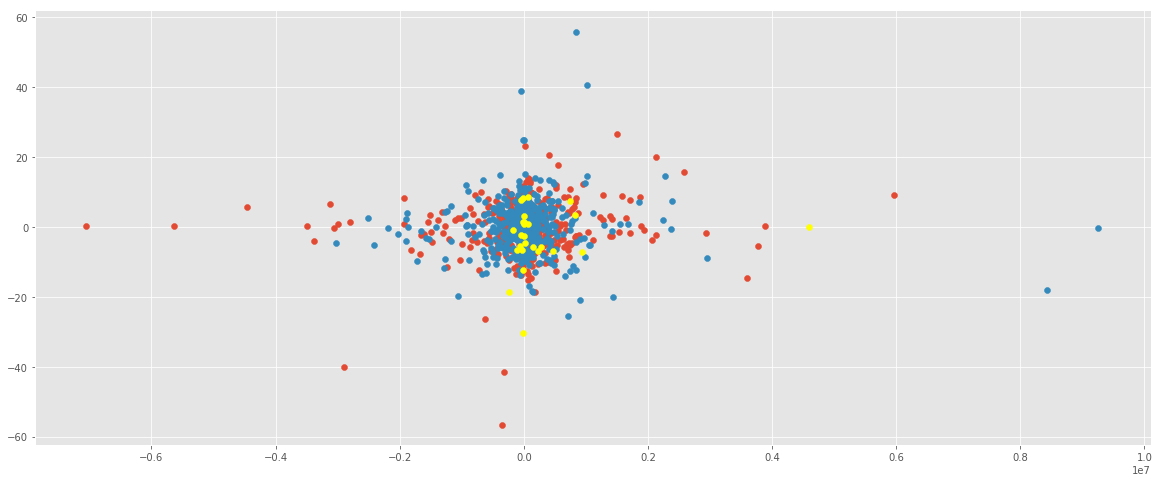

In [346]:
plot_GOP = rematch_GOP[['delta_vote', 'delta_spend']]
plot_Dem = rematch_Dem[['delta_vote', 'delta_spend']]
plot_Ind = rematch_Ind[['delta_vote', 'delta_spend']]

x = plot_GOP['delta_vote']
y = plot_GOP['delta_spend']
w = plot_Dem['delta_vote']
z = plot_Dem['delta_spend']
t = plot_Ind['delta_vote']
u = plot_Ind['delta_spend']

fig, ax = plt.subplots(1, figsize=(20,8))
ax.scatter(y, x)
ax.scatter(z, w)
ax.scatter(u, t, color='yellow')


In [347]:
def plot_state(state_name):
    state_df = rematch4[rematch4['state']== state_name]
    plot_state = state_df[['delta_vote', 'delta_spend']]
    x = plot_state['delta_spend']
    y = plot_state['delta_vote']
    fig, ax = plt.subplots(1, figsize=(20,8))
    ax.scatter(x, y)

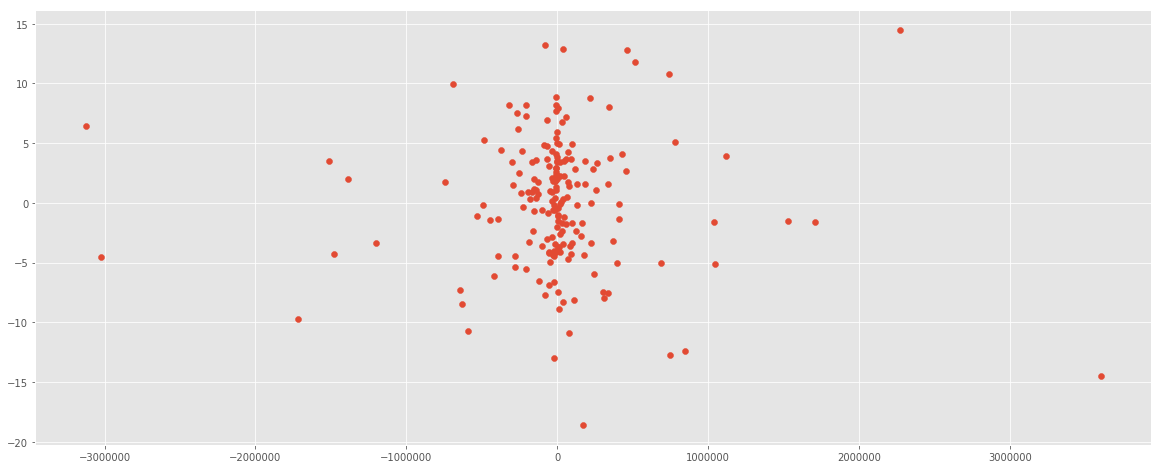

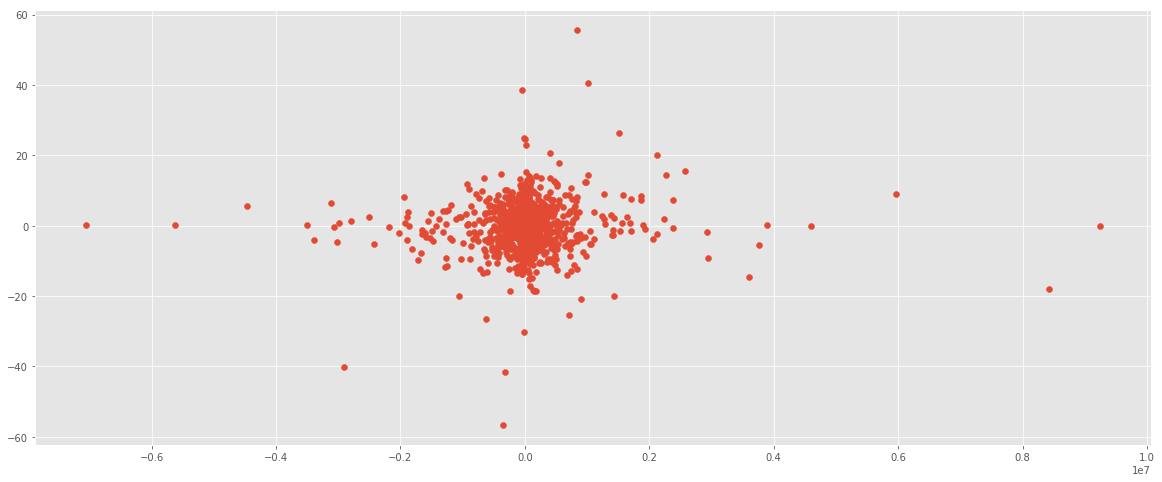

In [295]:
awesome = rematch_cut[rematch_cut['delta_vote']!=0]
test_plot_df = awesome[['delta_vote', 'delta_spend']]

x = test_plot_df['delta_vote']
y = test_plot_df['delta_spend']

fig, ax = plt.subplots(1, figsize=(20,8))
ax.scatter(y, x)

In [284]:
rematch_cut.shape

(13094, 16)

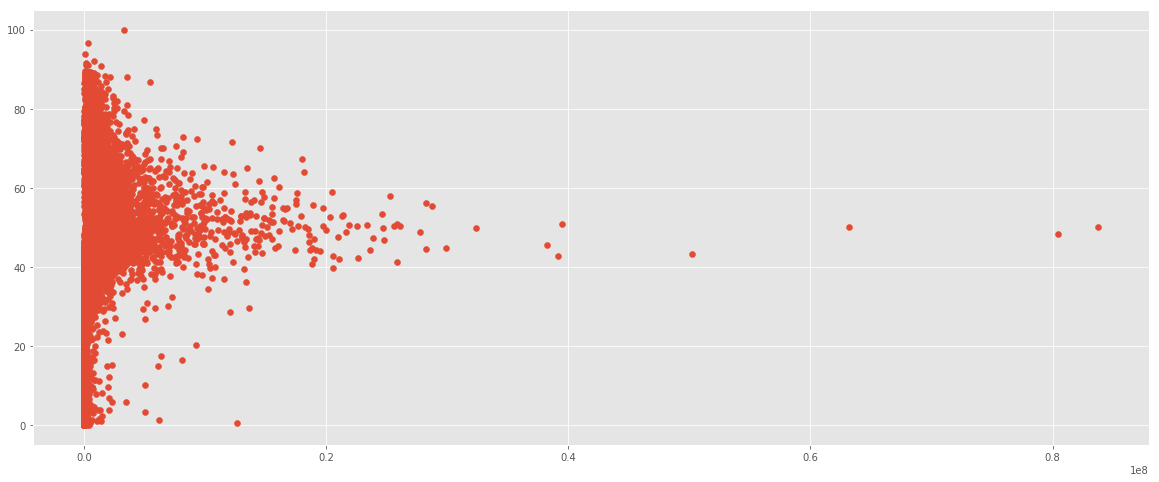

In [353]:
plot_money = merge_df_cut[['vote%', 'TTL_DISB']]
x = plot_money['TTL_DISB']
y = plot_money['vote%']

fig, ax = plt.subplots(1, figsize=(20,8))
ax.scatter(x,y)

In [264]:
save = rematch_cut.copy()

In [259]:
for i in range(len(rematch_list)):
    a = rematch_cut[rematch_cut['new_elec_id']==list(rematch_list[i])[0]]
    b = rematch_cut[rematch_cut['new_elec_id']==list(rematch_list[i])[1]]
    a.set_index('candidate')
    b.set_index('candidate')
''' i1 = a['index'][0]
    i2 = a['index'][1]
    i3 = b['index'][0]
    i4 = b['index'][1]

    #calc delta_vote
    if a.loc[0,'office'] == a.loc[1,'office']:
        d_vote = a.loc[0, 'vote%'] - b.loc[0,'vote%']
        rematch_cut.loc[i1, 'delta_vote'] = d_vote
        rematch_cut.loc[i3, 'delta_vote'] = 0    

        d2_vote = a.loc[1, 'vote%'] - b.loc[1,'vote%']
        rematch_cut.loc[i2, 'delta_vote'] = d2_vote
        rematch_cut.loc[i4, 'delta_vote'] = 0 
    else: 
        rematch_cut.loc[i1, 'delta_vote'] = None
        rematch_cut.loc[i3, 'delta_vote'] = None
        rematch_cut.loc[i2, 'delta_vote'] = None
        rematch_cut.loc[i4, 'delta_vote'] = None 

    # calc delta_spend
    if a.loc[0,'office'] == a.loc[1,'office']:
        d_vote = a.loc[0, 'TTL_DISB'] - b.loc[0,'TTL_DISB']
        rematch_cut.loc[i1, 'delta_spend'] = d_vote
        rematch_cut.loc[i3, 'delta_spend'] = 0    

        d2_vote = a.loc[1, 'TTL_DISB'] - b.loc[1,'TTL_DISB']
        rematch_cut.loc[i2, 'delta_spend'] = d2_vote
        rematch_cut.loc[i4, 'delta_spend'] = 0 
    else: 
        rematch_cut.loc[i1, 'delta_spend'] = None
        rematch_cut.loc[i3, 'delta_spend'] = None
        rematch_cut.loc[i2, 'delta_spend'] = None
        rematch_cut.loc[i4, 'delta_spend'] = None '''

8396

In [179]:
get_rematch_table(3)

,FEC_ID,new_elec_id,candidate,candidatevotes,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB
1689,H6CA36026,1980-CA-36,George E. Brown Jr.,88628,US House,democrat,California,36,I,168690,89317.0,84680.0
1690,H0CA36011,1980-CA-36,Harry J. Histen,6815,US House,libertarian,California,36,NaN,168690,1417.0,1417.0
1691,H0CA36052,1980-CA-36,John Paul Stark,73247,US House,republican,California,36,NaN,168690,28497.0,28103.0
2427,H0CA36052,1982-CA-36,John Paul Stark,64361,US House,republican,California,36,NaN,140907,152727.0,172917.0
2428,H6CA36026,1982-CA-36,"George E. Brown, Jr.",76546,US House,democrat,California,36,I,140907,394704.0,386013.0
3164,H0CA36052,1984-CA-36,John Paul Stark,80212,US House,republican,California,36,C,184650,378330.0,375356.0
3165,H6CA36026,1984-CA-36,George E. Brown Jr.,104438,US House,democrat,California,36,I,184650,669003.0,668299.0
4610,H6CA36026,1988-CA-36,"George E. Brown, Jr.",103493,US House,democrat,California,36,I,191648,504361.0,532897.0
4611,H0CA36052,1988-CA-36,John Paul Stark,81413,US House,republican,California,36,C,191648,219019.0,218696.0
4612,H0CA33018,1988-CA-36,Fred L. Anderson,3360,US House,independent,California,36,NaN,191648,2400.0,2391.0


In [120]:
merge_df_cut.columns

Index(['candidate', 'candidatevotes', 'district', 'mode', 'office', 'party',
       'runoff', 'special', 'stage', 'state', 'state_cen', 'state_fips',
       'state_ic', 'state_po', 'totalvotes', 'unofficial', 'version',
       'writein', 'year', 'district_str', 'vote%', 'elec_id', 'last_name',
       'elec-cand', 'FEC_ID', 'NAME', 'INC_STATUS', 'PTY_CD', 'PARTY',
       'TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TTL_DISB', 'TRANS_TO_AUTH',
       'CASH_BEGIN', 'CASH_END', 'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS',
       'CAND_LOAN_REPAY', 'OTHER_LOAN_REPAY', 'DEBTS_OWED_BY',
       'TTL_INDIV_CONTRIB', 'STATE', 'DISTRICT', 'SPEC_ELEC', 'PRIM_ELEC',
       'RUN_ELEC', 'GEN_ELEC', 'GEN_ELEC_PRECENT', 'OTHER_POL_CMTE_CONTRIB',
       'POL_PTY_CONTRIB', 'CVG_END_DT', 'INDIV_REFUNDS', 'CMTE_REFUNDS',
       'YEAR', 'LAST_NAME', 'ELEC_ID', 'ELEC-CAND', 'new_elec_id'],
      dtype='object')

In [119]:
top2_cand = merge_df_cut.groupby('new_elec_id')['vote%'].nlargest(2)
top2_cand.index[0]



('1980-AK-SE', 1597)

In [170]:
murkowski_young = merge_df_cut[merge_df_cut.loc[:, 'new_elec_id'].isin(rematch_list[1])]
murko_young = murkowski_young[['new_elec_id','candidate', 'candidatevotes', 'vote%', 'office', 'party', 'state', 'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]
murko_young['vote/dollar'] = murko_young['candidatevotes'] / murko_young['totalvotes']
murko_young

/Users/Kelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,new_elec_id,candidate,candidatevotes,vote%,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB,vote/dollar
1628,1980-CA-09,William J. (Bill) Kennedy,67265,41.117536,US House,republican,California,9,NaN,163592,31048.0,28806.0,0.411175
1629,1980-CA-09,Fortney H. (Pete) Stark,90504,55.322999,US House,democrat,California,9,I,163592,32603.0,47194.0,0.553230
2379,1982-CA-09,Fortney H. (Pete) Stark,104393,60.660101,US House,democrat,California,9,I,172095,318117.0,329628.0,0.606601
2380,1982-CA-09,Bill Kennedy,67702,39.339899,US House,republican,California,9,NaN,172095,140840.0,154311.0,0.393399
